In [21]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy estimation for classification

This notebook contains benchmarks for the _protopipe_ pipeline regarding information from training data used for the training of the classification model.  
It therefore uses the _gamma-2_ sample.

Only valid showers (meaning reconstructed with success) are considered.

## Imports

In [22]:
import os
from pathlib import Path

import tables
import pandas
import numpy as np
from scipy.stats import binned_statistic
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Functions

In [23]:
def get_camera_names(inputPath = None, fileName = None):
    """Read the names of the cameras.
    
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    camera_names : list(str)
        Table names as a list.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    h5file = tables.open_file(os.path.join(inputPath, fileName), mode='r')
    group = h5file.get_node("/")
    camera_names = [x.name for x in group._f_list_nodes()]
    h5file.close()
    return camera_names

In [24]:
def load_reset_infile_protopipe(inputPath = None, fileName = None, camera_names=None):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type.
     
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    dataFrames : dict(pandas.DataFrame)
        Dictionary of tables per camera.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    if camera_names is None:
        print("ERROR: no cameras specified")
    # load DL1 images
    dataFrames = {camera : pandas.read_hdf(os.path.join(inputPath, fileName), f"/{camera}") for camera in camera_names}
    return dataFrames

## Input data

### protopipe

In [25]:
# Modify these variables according to your local setup outside of the Vagrant Box
parentDir = "/Users/michele/Applications/ctasoft/dirac" # path to 'shared_folder'
analysisName = "v0.4.0_dev1"

indir = os.path.join(parentDir, 
                      "shared_folder/analyses", 
                      analysisName, 
                      "data/TRAINING/for_particle_classification")
infile = "TRAINING_classification_tail_gamma_merged.h5"

cameras = get_camera_names(inputPath = indir,
                                   fileName = infile)
data = load_reset_infile_protopipe(inputPath = indir,
                                   fileName = infile,
                                   camera_names=cameras)

In [26]:
# select only successfully reconstructed showers
valid_showers = {}
for camera in cameras:
    valid_showers[camera] = data[camera][(data[camera]["is_valid"]==True)]

In [27]:
# then merge the tables
for i, camera in enumerate(cameras):
    if i==0:
        all_valid_showers = valid_showers[camera]
    else:
        all_valid_showers = all_valid_showers.append(valid_showers[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_all_valid_showers = all_valid_showers.drop_duplicates(subset=['event_id'])

### CTAMARS

In [28]:
indir_refData = "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2019/CTAMARS_reference_data/TRAINING/DL2" # path to CTAMARS ROOT file
mars_dl2b_energy_fileName = "CTA_4L15M_check_Erec.root"
path_mars_dl2b_energy = os.path.join(indir_refData, mars_dl2b_energy_fileName)

In [29]:
with uproot.open(path_mars_dl2b_energy) as CTAMARS:
    CTAMARS_Eres = CTAMARS["Eres"]

## Energy dispersion

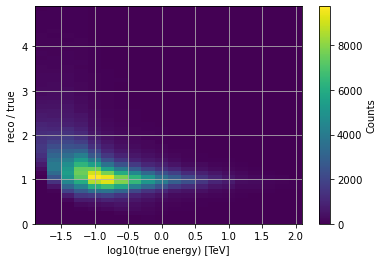

In [30]:
x = np.log10(unique_all_valid_showers["true_energy"].values)
y = unique_all_valid_showers["reco_energy"].values / unique_all_valid_showers["true_energy"].values

bin_edges_x = np.arange(-1.9, 2.3, 1/5)
bin_edges_y = np.arange(0, 5, 1/10)

plt.hist2d(x, y, bins=[bin_edges_x, bin_edges_y])
plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('reco / true')

None # to remove clutter by mpl objects

## Energy resolution

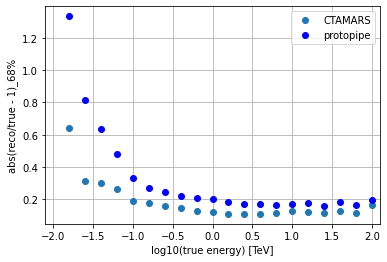

In [31]:
reco = unique_all_valid_showers["reco_energy"].values
true = unique_all_valid_showers["true_energy"].values

def resolution(x):
    return np.percentile(x, 68)

h = binned_statistic(np.log10(true), 
                     np.abs(reco/true - 1), 
                     statistic=resolution, 
                     bins=bin_edges_x,)

plt.plot(CTAMARS_Eres.members["fX"],CTAMARS_Eres.members["fY"], 'o', ls="None", label="CTAMARS")

plt.plot(0.5 * (h[1][:-1] + h[1][1:]), h[0], "bo", label="protopipe")

plt.grid(which="both", axis="both")
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('abs(reco/true - 1)_68%')
plt.xlim(-2.1, 2.1)
plt.legend(loc="best")

None # to remove clutter by mpl objects

## Migration energy matrix

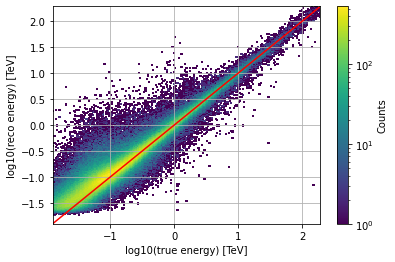

In [32]:
x = np.log10(unique_all_valid_showers["true_energy"].values)
y = np.log10(unique_all_valid_showers["reco_energy"].values)

bin_edges = np.arange(-1.9, 2.3, 1/50)

plt.hist2d(x, y, bins=[bin_edges, bin_edges], norm=LogNorm())
plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('log10(reco energy) [TeV]')

plt.plot(bin_edges, bin_edges, color="red")

None # to remove clutter by mpl objects